In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
import sys
# メモリ確認用 https://qiita.com/AnchorBlues/items/883790e43417640140aa
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 


In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

# 価格関連の特徴量作成をします
## GOAL:
* 「前の週からの価格変動」特徴量
* ~~「過去28日間の売り上げ平均」特徴量~~
    * ~~1日目~28日目までについては取扱開始後28日間の平均を用いる~~
* 「28日前~55日前の売り上げ平均」特徴量
    * 1日目~55日目までについては取扱開始後55日目の値を用いる
* 「新商品」flag

の作成

# データの読み込み

In [3]:
pri = pd.read_csv('./data/sell_prices.csv')
# data_ex = pd.read_csv('./data/backup/data_ex2.csv')
data_ex = pd.read_csv('./data/backup/data_ex3.csv')
# data_ex.drop(["new_item", "pri_fluc"], axis=1, inplace=True)

In [4]:
pri.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [48]:
data_ex.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan,28day_sales,new_item,pri_fluc
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
1,HOBBIES_1_008_CA_1_validation,1444,2,15,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
2,HOBBIES_1_008_CA_1_validation,1444,3,0,31,11101,3,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
3,HOBBIES_1_008_CA_1_validation,1444,4,0,1,11101,4,2,2011,30,4,1,1,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
4,HOBBIES_1_008_CA_1_validation,1444,5,0,2,11101,5,2,2011,30,4,1,0,1,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0


# 新商品flag

In [40]:
## pandas.dataframe.ne() とかいうのがあるらしい
## https://stackoverflow.com/questions/40348541/pandas-diff-with-string
pri["new_item_tmp"] = (((pri["item_id"].ne(pri["item_id"].shift().bfill())) |
                    (pri["store_id"].ne(pri["store_id"].shift().bfill())))).astype(int)
pri["new_item_tmp"][0] = 1
pri["new_item"] = pri["new_item_tmp"] * (pri["wm_yr_wk"]!=11101).astype(int)

pri.head()
# new_item_tmp --> 価格変動計算用 (初登場時の価格変動を0にする)
# new_item --> new_item flag 用 (時系列の始まりに登場する商品の多くは明らかに new_itam ではない)

<ipython-input-40-dbef9216716e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pri["new_item_tmp"][0] = 1


,store_id,item_id,wm_yr_wk,sell_price,new_item_tmp,new_item
0,CA_1,HOBBIES_1_001,11325,9.58,1,1
1,CA_1,HOBBIES_1_001,11326,9.58,0,0
2,CA_1,HOBBIES_1_001,11327,8.26,0,0
3,CA_1,HOBBIES_1_001,11328,8.26,0,0
4,CA_1,HOBBIES_1_001,11329,8.26,0,0


### データの初めの方は明らかに外れ値

<AxesSubplot:xlabel='wm_yr_wk', ylabel='count'>

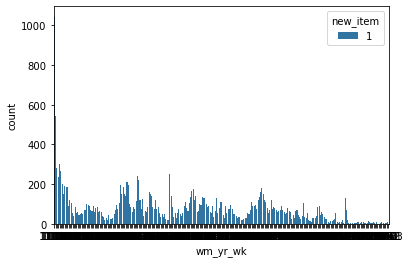

In [104]:
sns.countplot(x="wm_yr_wk", hue="new_item", data=pri[(pri["new_item"]==1)])

<AxesSubplot:xlabel='wm_yr_wk', ylabel='count'>

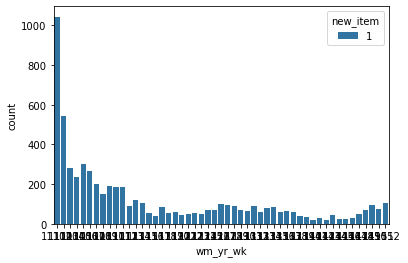

In [105]:
sns.countplot(x="wm_yr_wk", hue="new_item", data=pri[(pri["new_item"]==1) & (pri["wm_yr_wk"]<11200)])

<AxesSubplot:xlabel='wm_yr_wk', ylabel='count'>

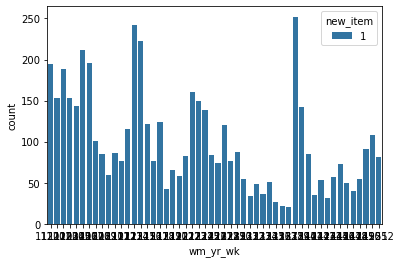

In [72]:
sns.countplot(x="wm_yr_wk", hue="new_item", data=pri[(pri["new_item"]==1) & (pri["wm_yr_wk"]<11300) & (pri["wm_yr_wk"]>=11200)])


<AxesSubplot:xlabel='wm_yr_wk', ylabel='count'>

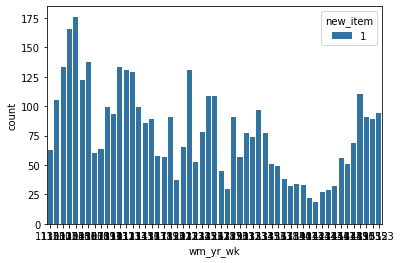

In [73]:
sns.countplot(x="wm_yr_wk", hue="new_item", data=pri[(pri["new_item"]==1) & (pri["wm_yr_wk"]<11400) & (pri["wm_yr_wk"]>=11300)])

In [75]:
pri[pri["new_item"]==1]["wm_yr_wk"].value_counts()[:20]

11102    1043
11103     544
11106     301
11104     280
11107     267
11239     252
11214     242
11105     234
11215     223
11206     212
11108     203
11207     196
11201     194
11110     192
11203     188
11112     186
11111     184
11405     182
11305     176
11304     166
Name: wm_yr_wk, dtype: int64

12年以降の最大値である「252 (wm_yr_wk=11239)」を上回る状態が続く「wm_yr_wk=11104」までは外れ値とし、new_item flag を 0 とする

In [41]:
pri["new_item"] = pri["new_item"].mask(pri["wm_yr_wk"]<11105, 0)

# 価格変動特徴量

In [42]:
# wm_yr_wk が連続しているかの調査
wm_ = pri["wm_yr_wk"].diff()
wm_[(wm_>1) & (wm_<45)]
# 価格登録がn週間欠落している、とかはないっぽい

Series([], Name: wm_yr_wk, dtype: float64)

In [43]:
tmp = pri["sell_price"].pct_change()
tmp[pri["new_item_tmp"]==1] = 0
pri["pri_fluc"] = tmp

In [44]:
pri["id2"] = pri["item_id"] + "_" + pri["store_id"] + "_" + pri["wm_yr_wk"].astype(str)
data_ex["id2"]= data_ex["id"].str.replace("_validation", "").str.replace("_evaluation", "") + "_" + data_ex['wm_yr_wk'].astype(str)

In [45]:
pri.drop(["store_id", "item_id", "wm_yr_wk", "sell_price", "new_item_tmp"], axis=1, inplace=True)
pri["pri_fluc"] = pri["pri_fluc"].round(3)

In [46]:
data_ex = pd.merge(data_ex, pri, on='id2')

In [47]:
data_ex.drop("id2", axis=1, inplace=True)

# ~~過去28日間の売り上げ~~

In [ ]:
data_ex = pd.read_csv('./data/backup/data_ex2.csv')
data_ex = data_ex[["id", "item_id", "date_id", "num", "sell_price"]]
data_ex["id2"]= data_ex["id"].str.replace("_validation", "").str.replace("_evaluation", "")

In [ ]:
tmp = data_ex.sort_values(['id2', 'date_id'])
del data_ex
tmp.reset_index(inplace=True)
tmp["count"] = tmp.groupby("id2").cumcount()
tmp["day_sales"] = tmp["num"]*tmp["sell_price"]
tmp['28day_sales'] = tmp['day_sales'].rolling(28).sum().round(2)

In [ ]:
# 1~27日目までを埋める値
_27th = tmp[tmp["count"]==27][["id2", "28day_sales"]].rename(columns={'28day_sales': '27th'})
tmp = pd.merge(tmp, _27th, on='id2')

In [64]:
# count が26以下の 28day_sales には 27th の値を挿入
tmp["28day_sales"] = tmp["28day_sales"].fillna(0)
tmp["27th"] = tmp["27th"] * (tmp["count"]<27).astype(int)
tmp["28day_sales"] = tmp["28day_sales"] * (tmp["count"]>=27).astype(int)
tmp["28day_sales"] = tmp["27th"] + tmp["28day_sales"]


In [70]:
tmp.set_index('index', inplace=True)
tmp.sort_index(inplace=True)

In [71]:
tmp.head()

,id,item_id,date_id,num,sell_price,id2,count,day_sales,28day_sales,27th
index,,,,,,,,,,
0,HOBBIES_1_008_CA_1_validation,1444,1,12,0.46,HOBBIES_1_008_CA_1,0,5.52,57.30,57.30
1,HOBBIES_1_009_CA_1_validation,1445,1,2,1.56,HOBBIES_1_009_CA_1,0,3.12,95.16,95.16
2,HOBBIES_1_010_CA_1_validation,1446,1,0,3.17,HOBBIES_1_010_CA_1,0,0.00,19.02,19.02
3,HOBBIES_1_012_CA_1_validation,1448,1,0,5.98,HOBBIES_1_012_CA_1,0,0.00,113.62,113.62
4,HOBBIES_1_015_CA_1_validation,1451,1,4,0.70,HOBBIES_1_015_CA_1,0,2.80,85.82,85.82


In [73]:
data_ex = pd.read_csv('./data/backup/data_ex2.csv')
data_ex["28day_sales"] = tmp["28day_sales"]
data_ex.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan,28day_sales
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.30
1,HOBBIES_1_009_CA_1_validation,1445,1,2,29,11101,1,1,2011,30,4,0,0,0,1.56,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,95.16
2,HOBBIES_1_010_CA_1_validation,1446,1,0,29,11101,1,1,2011,30,4,0,0,0,3.17,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,19.02
3,HOBBIES_1_012_CA_1_validation,1448,1,0,29,11101,1,1,2011,30,4,0,0,0,5.98,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,113.62
4,HOBBIES_1_015_CA_1_validation,1451,1,4,29,11101,1,1,2011,30,4,0,0,0,0.70,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,85.82


In [49]:
# Backup
data_ex.to_csv('./data/backup/data_ex3.csv', index=False)

# 28日前~55日前の28日間の売上

In [3]:
data_ex = pd.read_csv('./data/backup/data_ex5B.csv')
data_ex_ = data_ex[["id", "item_id", "date_id", "num", "sell_price"]]
data_ex_["id2"]= data_ex_["id"].str.replace("_validation", "").str.replace("_evaluation", "")

<ipython-input-3-ba238dc02589>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ex_["id2"]= data_ex_["id"].str.replace("_validation", "").str.replace("_evaluation", "")


In [4]:
tmp = data_ex_.sort_values(['id2', 'date_id'])
del data_ex_
tmp.reset_index(inplace=True)
tmp["count"] = tmp.groupby("id2").cumcount()
tmp["day_sales"] = tmp["num"]*tmp["sell_price"]

In [5]:
# tmp['28_35_sales'] = tmp['day_sales'].rolling(28).sum().round(2)
tmp['28_35_sales'] = tmp['day_sales'].rolling(56).sum() - tmp['day_sales'].rolling(28).sum()

In [6]:
tmp['28_35_sales'] = tmp['28_35_sales'].round(2)

In [7]:
# 1~55日目までを埋める値
_55th = tmp[tmp["count"]==55][["id2", "28_35_sales"]].rename(columns={'28_35_sales': '55th'})
tmp = pd.merge(tmp, _55th, on='id2')

In [8]:
# count が54以下の 28_35_sales には 55th の値を挿入
tmp["28_35_sales"] = tmp["28_35_sales"].fillna(0)
tmp["55th"] = tmp["55th"] * (tmp["count"]<55).astype(int)
tmp["28_35_sales"] = tmp["28_35_sales"] * (tmp["count"]>=55).astype(int)
tmp["28_35_sales"] = tmp["55th"] + tmp["28_35_sales"]


In [9]:
tmp.set_index('index', inplace=True)
tmp.sort_index(inplace=True)

In [12]:
data_ex["28_55_sales"] = tmp["28_35_sales"]
data_ex.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,...,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan,28day_sales,new_item,pri_fluc,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,corr,28_55_sales
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,57.30,0,0.0,55.7,69.1,45.0,1011.1,0.7,0.00,0.0,24.1,-5.3,0,0,0,0,0,0,1,-0.730432,57.30
1,HOBBIES_1_008_CA_3_validation,1444,1,11,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,230.38,0,0.0,55.7,69.1,45.0,1011.1,0.7,0.00,0.0,24.1,-5.3,0,0,0,0,0,0,1,-0.730432,230.38
2,HOBBIES_1_008_CA_1_validation,1444,2,15,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,57.30,0,0.0,55.3,62.1,53.1,1013.4,1.1,0.00,0.0,9.0,-0.4,0,1,0,0,0,0,0,-0.730432,57.30
3,HOBBIES_1_008_CA_3_validation,1444,2,12,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,230.38,0,0.0,55.3,62.1,53.1,1013.4,1.1,0.00,0.0,9.0,-0.4,0,1,0,0,0,0,0,-0.730432,230.38
4,HOBBIES_1_008_CA_1_validation,1444,3,0,31,11101,3,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,57.30,0,0.0,54.0,64.9,45.0,1012.2,0.8,0.21,0.0,19.9,-1.3,0,0,0,0,0,0,0,-0.730432,57.30


In [13]:
data_ex.to_csv('./data/backup/data_ex6B.csv', index=False)

# データの可視化

## 準備

In [50]:
data_ex = pd.read_csv("./data/backup/data_ex3.csv")
data_ex.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan,28day_sales,new_item,pri_fluc
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
1,HOBBIES_1_008_CA_1_validation,1444,2,15,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
2,HOBBIES_1_008_CA_1_validation,1444,3,0,31,11101,3,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
3,HOBBIES_1_008_CA_1_validation,1444,4,0,1,11101,4,2,2011,30,4,1,1,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0
4,HOBBIES_1_008_CA_1_validation,1444,5,0,2,11101,5,2,2011,30,4,1,0,1,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.3,0,0.0


## 新商品

In [52]:
ni = data_ex[["id", "item_id", "date_id", "year", "month", "date", "new_item"]]

In [53]:
ni

,id,item_id,date_id,year,month,date,new_item
0,HOBBIES_1_008_CA_1_validation,1444,1,2011,1,29,0
1,HOBBIES_1_008_CA_1_validation,1444,2,2011,1,30,0
2,HOBBIES_1_008_CA_1_validation,1444,3,2011,1,31,0
3,HOBBIES_1_008_CA_1_validation,1444,4,2011,2,1,0
4,HOBBIES_1_008_CA_1_validation,1444,5,2011,2,2,0
...,...,...,...,...,...,...,...
47735392,FOODS_3_825_WI_3_evaluation,1434,1969,2016,6,19,0
47735393,FOODS_3_826_WI_3_evaluation,1435,1968,2016,6,18,0
47735394,FOODS_3_826_WI_3_evaluation,1435,1969,2016,6,19,0
47735395,FOODS_3_827_WI_3_evaluation,1436,1968,2016,6,18,0


In [54]:
grouped = ni.groupby(['year', 'month'])
tmp = grouped.sum()
tmp.reset_index(inplace=True)
tmp = tmp[["year","month","new_item"]]
tmp.head()
for i in range(7,13):
    tmp = tmp.append(pd.DataFrame([[2016, i, 0]], columns=["year", "month", "new_item"]))
tmp.reset_index(inplace=True)

/home/usrs/tack/miniconda/miniconda3/envs/moji/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


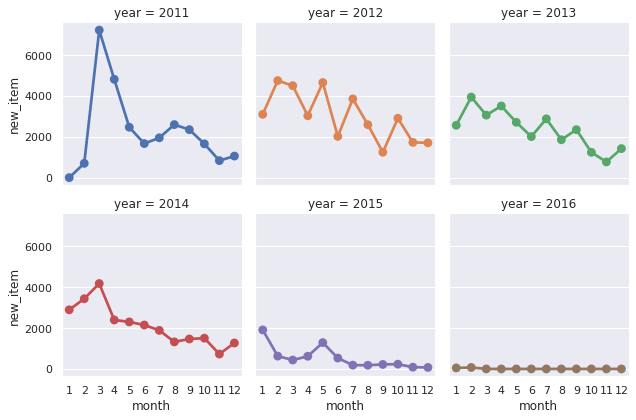

In [55]:
grid = sns.FacetGrid(tmp, col="year", hue="year", col_wrap=3)
grid.map(sns.pointplot, 'month', 'new_item')

<AxesSubplot:xlabel='month', ylabel='year'>

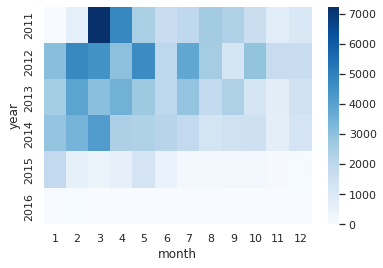

In [56]:
# https://qiita.com/hik0107/items/67ad4cfbc9e84032fc6b
df_flights_pivot = pd.pivot_table(data=tmp, values='new_item', columns='month', index='year', aggfunc=np.mean)
sns.heatmap(df_flights_pivot, cmap='Blues')

* 新商品の取り扱い開始は比較的上半期に多い
* とりわけ 11月、12月 は比較的少ない。これはブラックフライデーやクリスマス等の年末商戦を睨み、早い段階から消費者へアプローチを行う必要があるからかもしれない
* 6月は前後の月と比べて比較的新商品の数が少ない。
* 与えられたデータに登録された商品はその多くが2014年までに登録されている
    * 購買予測のために新製品を除外している? 2016/3月以降に新商品 flag が立たないのは大変不自然。
    * 2011年から商品のPOSシステムへの登録を開始し、2014年中までにほとんどの製品のPOSシステムへの登録が完了した？
* 注意) 2011/1 の全て及び 2011/2 の一部の flag は外れ値除去のため排除しているため、この期間のデータは当てにならない
* 注意) 新商品flag は1週間にわたってたつため、表中の数値は新商品の数ではない (実際の数は「おおよそ」1/7)

## 価格変動特徴量

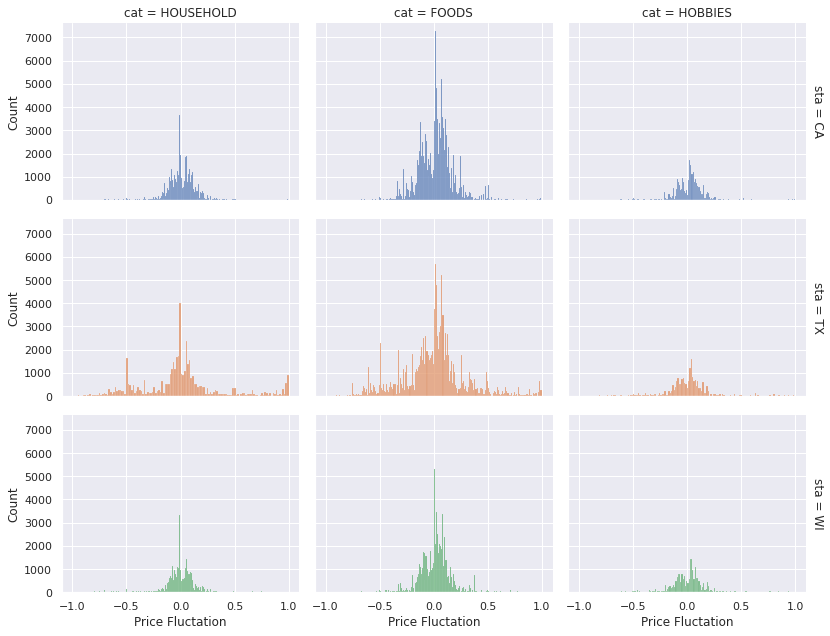

In [51]:
grid = sns.FacetGrid(data_ex[(data_ex["pri_fluc"]<1) & (data_ex["pri_fluc"]>-1) & (data_ex["pri_fluc"]!=0)], col="cat", row="sta", hue="sta", height=3, aspect=1.3, margin_titles=True)
grid.map(sns.histplot, "pri_fluc")
for ax in grid._bottom_axes:
    ax.set_xlabel('Price Fluctation')

* 3つのカテゴリーのうち、foods が最も価格の変動が発生している。
* HOUSEHOLD, FOODS の価格変動は州毎にかなり異なるのに対し、HOBBIES の価格変動は 3州 とも同程度に見える。HOBBIES については全店舗である程度連携した価格設定になっているのかもしれない。
* 3州のうち、最も価格変動が激しいのは TX州 であり、逆に変動が小さいのは WI州 に見える。
* とりわけ TX州 では、FOODS, HOUSEHOLD での大規模な価格変動が他の州に比べてかなり頻繁に起こっている。

## 過去28日間の売り上げ

In [16]:
tmp = data_ex["id"].str.split(pat='_', expand=True)
data_ex["store"] = tmp[3] + "_" + tmp[4]

Text(0.5, 1.0, '28days sales: HOBBIES_1_008')

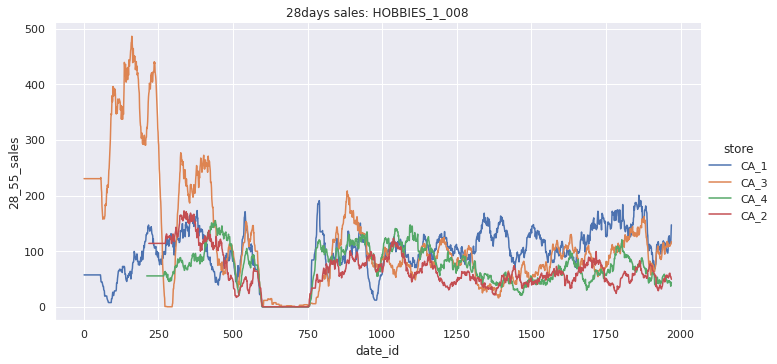

In [20]:
sns.relplot(x="date_id", y="28_55_sales", data=data_ex[(data_ex["item_id"]==1444) & (data_ex["state_id_CA"]==1)], kind='line', aspect=2, hue="store")
plt.title('28days sales: HOBBIES_1_008')

Text(0.5, 1.0, '28days sales: FOODS_1_002')

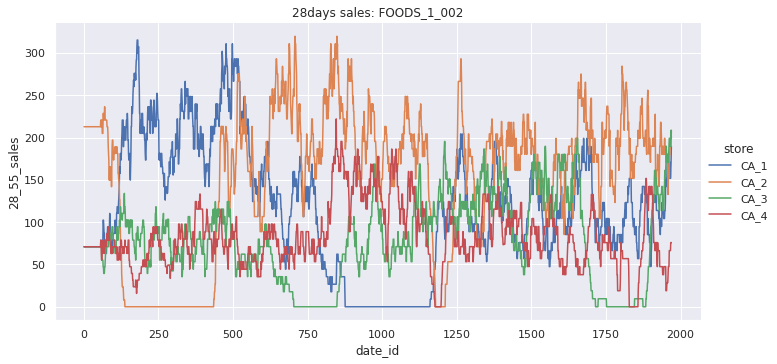

In [21]:
sns.relplot(x="date_id", y="28_55_sales", data=data_ex[(data_ex["item_id"]==1) & (data_ex["state_id_CA"]==1)], kind='line', aspect=2, hue="store")
plt.title('28days sales: FOODS_1_002')

Text(0.5, 1.0, '28days sales: HOUSEHOLD_2_368')

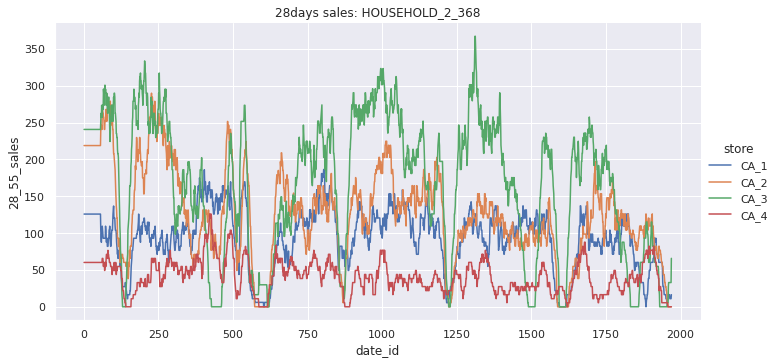

In [22]:
sns.relplot(x="date_id", y="28_55_sales", data=data_ex[(data_ex["item_id"]==2900) & (data_ex["state_id_CA"]==1)], kind='line', aspect=2, hue="store")
plt.title('28days sales: HOUSEHOLD_2_368')

* 売り上げが不自然に0になっている区間がある
   * --> 在庫切れや、納品待ち、メーカーの都合で製造ができないとかがありそう
   * 売り上げ個数の予測の目的の一つには、欠品を防ぐ目的もあると思われる。このためには0があまりにも連続する区間は邪魔
   * 一方で、季節商品とかがある可能性もある。0の区間を消してしまっては、季節性を掴めなくなる。